In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import copy
from pathlib import Path 

In [5]:
# Load the autoreload extension
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Imported the module
from Model_CAR_NK import Model_obj_CAR_NK as obj_CAR_NK
from Model_Wt_NK import Model_obj_WT_NK as obj_WT_NK
from fitting import Model_fit, Model_Pred

In [7]:
Sys_CAR_Her2 = obj_CAR_NK()
Sys_WT_NK = obj_WT_NK()

In [8]:
donor ='C'

In [9]:
file_path = Path.cwd().parents[0] / 'data/SKOV3_DIPG36_Her2'
Cytof_data = pd.ExcelFile(f'{file_path}/Donor_C_D_ Her2 Cytotoxicity.xlsx')
sheet_names =  [item for i, item in enumerate(Cytof_data.sheet_names) if item.startswith(donor)]
data_SKOV3 = Cytof_data.parse(sheet_names[0])
data_SKOV3 = data_SKOV3.iloc[9:16,0:10].reset_index(drop=True)
ET_ratio = data_SKOV3.iloc[1:8,0:1].values.flatten()
data_SKOV3_WT = (data_SKOV3.iloc[1:8,1:4].values).astype(np.float64)
data_SKOV3_Her2_CAR = (data_SKOV3.iloc[1:8,4:7].values).astype(np.float64)
data_DIPG36 = Cytof_data.parse(sheet_names[1])
data_DIPG36 = data_DIPG36.iloc[9:16,0:10].reset_index(drop=True)
data_DIPG36_WT = (data_DIPG36.iloc[1:8,1:4].values).astype(np.float64)
data_DIPG36_Her2_CAR = (data_DIPG36.iloc[1:8,4:7].values).astype(np.float64)

In [10]:
LB = np.array([1.0e-1,200,0.1,0.1,100,
               0.1,
               0.1,0.1,
               1.5e-7])
UB = np.array([0.99,2.0e+3,1.0,1.0,10000,
               1.0,
               1.0,1.0,
               1.e-4])

In [11]:
# Choose optimizer from the list below
opt = ['least_squares','minimize','pso','differential_evolution']

In [12]:
def main_Fit():
    MFI_limt = [[(0, 50), (0, 170), (0.0, 100.0)], [(0, 10), (0, 120), (0.0, 250.0)]]
    Sys_CAR_Her2.Cell_type_R_L(NK_cell=f'CAR-NK {donor}', Tumor_cell='DIPG36',limts=MFI_limt)
    Sys_WT_NK.Cell_type_R_L(NK_cell=f'WT {donor}', Tumor_cell='DIPG36',limts=MFI_limt)
    model_sys = (Sys_CAR_Her2, Sys_WT_NK)
    data = (np.mean(data_DIPG36_Her2_CAR,axis=1),np.mean(data_DIPG36_WT,axis=1),ET_ratio)
    x0 =[0.8483, 200.0, 0.1713, 1.0, 1534.0, 0.1, 0.1, 0.1, 9.999e-05]
    return Model_fit(x0,LB,UB,model_sys,data,optimizer=opt[0],fit=False)
res0 = main_Fit()

----- Optimized Parameters (2 sig. digits) -----
[0.8483, 200.0, 0.1713, 1.0, 1534.0, 0.1, 0.1, 0.1, 9.999e-05]
Cost = 509
Total Cost: 508.87909009366183


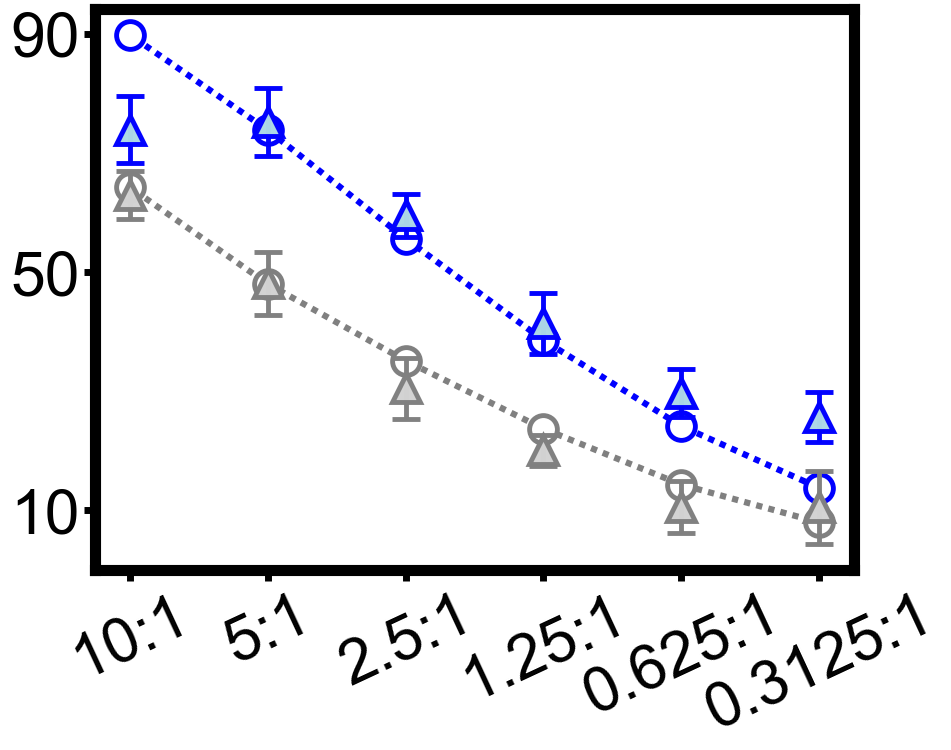

In [13]:
plt.figure(figsize=(10,8))
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=5)
ls = [(1,(1,1)),(5, (10, 3)), (0,(2,2)), (0, (3, 1, 1, 1))]
m_size = 20
lw = 4.5
plt.plot(np.arange(len(ET_ratio)), res0[0], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='blue',color = 'blue',lw=lw,ls = ls[0])#,label="Fit-CAR-DIPG36")
plt.plot(np.arange(len(ET_ratio)), res0[1], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='gray',color = 'gray',lw=lw,ls = ls[0])#,label="Fit-WT-DIPG36")

plt.errorbar(np.arange(len(ET_ratio)), np.mean(data_DIPG36_Her2_CAR,axis=1), yerr = np.std(data_DIPG36_Her2_CAR,axis=1), 
             fmt='^', markersize=m_size, markerfacecolor='lightblue', markeredgewidth=3.5, markeredgecolor='blue',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='blue',alpha=0.99)#,label="data-Gen2")

plt.errorbar(np.arange(len(ET_ratio)),np.mean(data_DIPG36_WT,axis=1), yerr = np.std(data_DIPG36_WT,axis=1), 
             fmt='^', markersize=m_size, markerfacecolor='lightgray', markeredgewidth=3.5, markeredgecolor='gray',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='gray',alpha=0.99)#,label="data-WT")
t_size = 45
plt.xticks(np.arange(len(ET_ratio)),ET_ratio,fontname="Arial",fontsize = t_size, rotation=25)
plt.yticks([10,50,90],fontname="Arial",fontsize = t_size)
#plt.tight_layout(pad=2.5)
#plt.title(f'DIPG36-CAR NK: {donor}',fontsize = t_size)
#plt.legend(bbox_to_anchor=(0.95, 1),fontsize=17, loc='upper right', labelcolor='white', frameon=False, ncol=1)
plt.tight_layout(pad=2.5)
plt.savefig(f'donor_{donor}_DIPG36_Fit_ET_vs_AvSpecificLysis_t_4h.png')
plt.show()

# Prediction SKOV3 by fitting WT

In [14]:
LB = np.array([700,700,1.7e-5])
UB = np.array([5500,6000,1.8e-4])

In [15]:
def main_Pred():
    MFI_limt = [[(0, 50), (0, 170), (0.0, 100.0)], [(0, 18), (0, 3), (0.0, 400.0)]]
    Sys_CAR_Her2.Cell_type_R_L(NK_cell=f'CAR-NK {donor}', Tumor_cell='SKOV3',limts=MFI_limt)
    Sys_WT_NK.Cell_type_R_L(NK_cell=f'WT {donor}', Tumor_cell='SKOV3',limts=MFI_limt)
    x0 = [5499.999975254983, 700.0000000000001, 8.663661190674548e-05]
    y0 = copy.deepcopy(res0[2])
    model_sys = (Sys_CAR_Her2, Sys_WT_NK)
    data = (np.mean(data_SKOV3_Her2_CAR,axis=1),np.mean(data_SKOV3_WT,axis=1),ET_ratio,y0)
    return Model_Pred(x0,LB,UB,model_sys,data,fit=False,only_wt=True)
res1 = main_Pred()

----- Optimized Parameters (2 sig. digits) -----
[5500.0, 700.0, 8.664e-05]
Cost = 112
Total Cost: 401.3658765017706


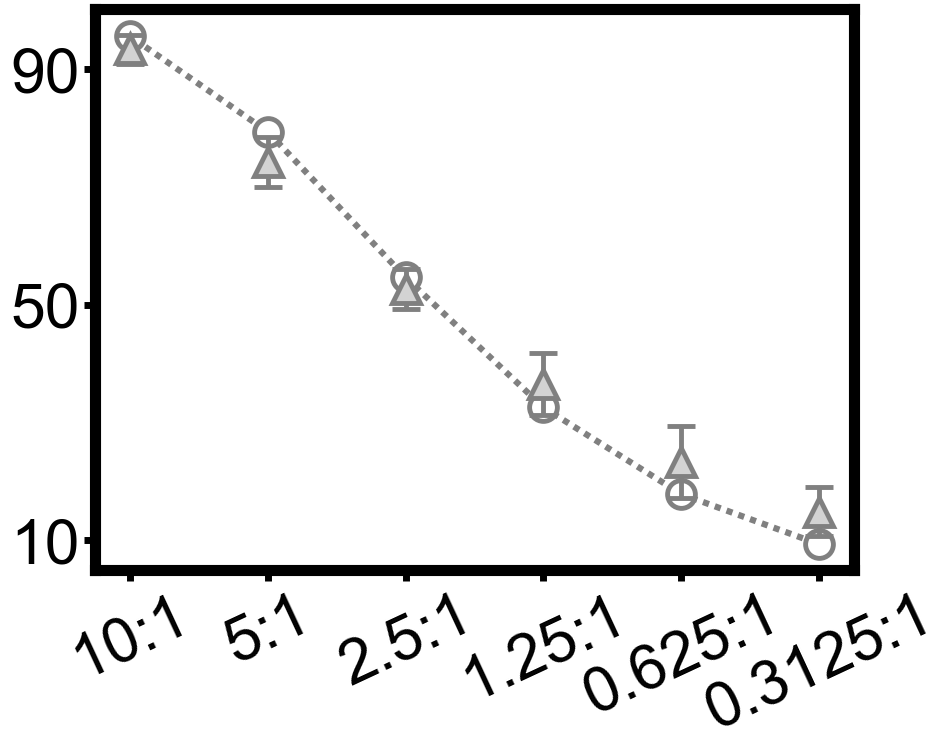

In [16]:
plt.figure(figsize=(10,8))
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=5)
ls = [(1,(1,1)),(5, (10, 3)), (0,(2,2)), (0, (3, 1, 1, 1))]
m_size = 20
lw = 4.5
plt.plot(np.arange(len(ET_ratio)),res1[1], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='gray',color = 'gray',lw=lw,ls = ls[0])#,label="Fit-WT")
plt.errorbar(np.arange(len(ET_ratio)), np.mean(data_SKOV3_WT,axis=1), yerr = np.std(data_SKOV3_WT,axis=1),
             fmt='^', markersize=m_size, markerfacecolor='lightgray', markeredgewidth=3.5, markeredgecolor='gray',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='gray')#,label="data-WT")
t_size = 45
plt.xticks(np.arange(len(ET_ratio)),ET_ratio,fontname="Arial",fontsize = t_size, rotation=25)
plt.yticks([10,50,90],fontname="Arial",fontsize = t_size)
#plt.title(f'SKOV3-WT: {donor}',fontsize = t_size)
plt.tight_layout(pad=2.5)
plt.savefig(f'donor_{donor}_SKOV3_WT_ET_vs_AvSpecificLysis_t_4h.png')
plt.show()

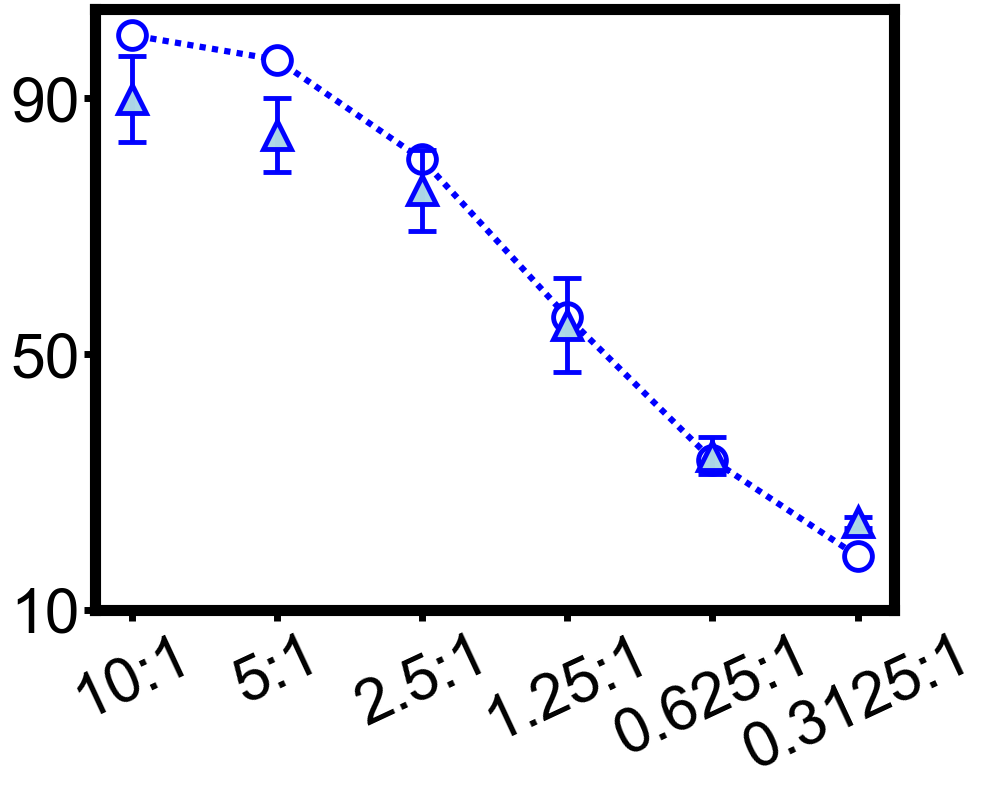

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=5)
ls = [(1,(1,1)),(5, (10, 3)), (0,(2,2)), (0, (3, 1, 1, 1))]
m_size = 20
lw = 4.5
plt.plot(np.arange(len(ET_ratio)), res1[0], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='blue',color = 'blue',lw=lw,ls = ls[0])#,label="Pred-CAR-SKOV3")

plt.errorbar(np.arange(len(ET_ratio)), np.mean(data_SKOV3_Her2_CAR,axis=1), yerr = np.std(data_SKOV3_Her2_CAR,axis=1), 
             fmt='^', markersize=m_size, markerfacecolor='lightblue', markeredgewidth=3.5, markeredgecolor='blue',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='blue',alpha=0.99)
t_size = 45
plt.xticks(np.arange(len(ET_ratio)),ET_ratio,fontname="Arial",fontsize = t_size, rotation=25)
plt.yticks([10,50,90],fontname="Arial",fontsize = t_size)
#plt.title(f'SKOV3-CAR NK: {donor}',fontsize = t_size)
plt.tight_layout(pad=1.05)
plt.savefig(f'donor_{donor}_SKOV3_Pred_ET_vs_AvSpecificLysis_t_4h.png')
plt.show()

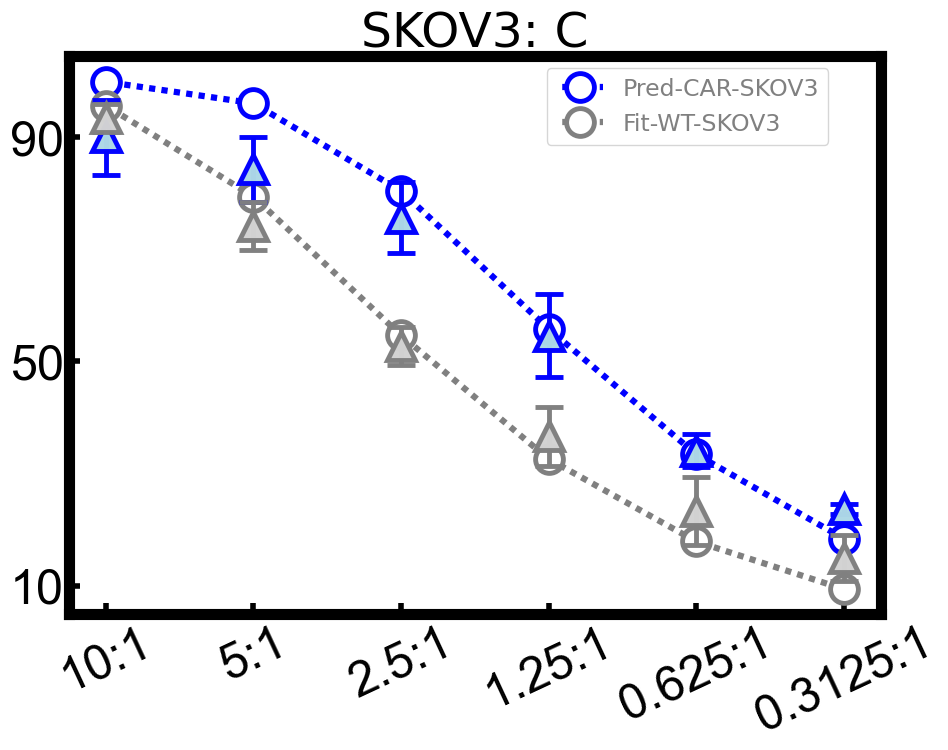

In [16]:
plt.figure(figsize=(10, 8))
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=4, direction='in')
ls = [(1, (1, 1)), (5, (10, 3)), (0, (2, 2)), (0, (3, 1, 1, 1))]
m_size = 20
lw = 4.5

plt.plot(np.arange(len(ET_ratio)), res1[0], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='blue', color='blue', lw=lw, ls=ls[0], label="Pred-CAR-SKOV3")
plt.plot(np.arange(len(ET_ratio)), res1[1], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='gray', color='gray', lw=lw, ls=ls[0], label="Fit-WT-SKOV3")

plt.errorbar(np.arange(len(ET_ratio)), np.mean(data_SKOV3_Her2_CAR, axis=1), yerr=np.std(data_SKOV3_Her2_CAR, axis=1),
             fmt='^', markersize=m_size, markerfacecolor='lightblue', markeredgewidth=3.5, markeredgecolor='blue',
             elinewidth=3.5, capsize=10, capthick=20, ecolor='blue', alpha=0.99)

plt.errorbar(np.arange(len(ET_ratio)), np.mean(data_SKOV3_WT, axis=1), yerr=np.std(data_SKOV3_WT, axis=1),
             fmt='^', markersize=m_size, markerfacecolor='lightgray', markeredgewidth=3.5, markeredgecolor='gray',
             elinewidth=3.5, capsize=10, capthick=20, ecolor='gray', alpha=0.99)

t_size = 35
plt.xticks(np.arange(len(ET_ratio)), ET_ratio, fontname="Arial", fontsize=t_size, rotation=25)
plt.yticks([10, 50, 90], fontname="Arial", fontsize=t_size)

plt.title(f'SKOV3: {donor}', fontsize=t_size)
plt.legend(bbox_to_anchor=(0.95, 1), fontsize=17, loc='upper right', labelcolor='gray')
plt.tight_layout(pad=2.5)  # Adjust padding to ensure ticks are inside
#plt.savefig(f'donor_{donor}_SKOV3_Pred_ET_vs_AvSpecificLysis_t_4h_margin_adjusted.png')
plt.show()

# Separate Figures

# $R^2$ Analysis

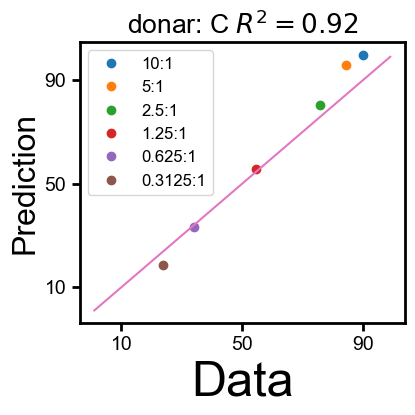

In [15]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 35
plt.rcParams['font.family'] = 'Arial'
fig, ax1 = plt.subplots(1,1,figsize = (5,5))

for i in range(len(res0[0])):
    ax1.plot(np.mean(data_SKOV3_Her2_CAR,axis=1)[i], res1[0][i], 'o', label=f'{ET_ratio[i]}')

ax1.plot(np.arange(1,100),np.arange(1,100))
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlabel('Data')
ax1.set_ylabel('Prediction',fontsize =23)
ax1.set_xticks([10,50,90])
ax1.set_yticks([10,50,90])
ax1.set_title(f'donar: {donor} $R^2 = {r2_score(np.mean(data_SKOV3_Her2_CAR,axis=1), res1[0]):.2f}$',fontsize =19)
ax1.tick_params(axis='both', which='major', labelsize=14, length=6,width=2)
ax1.legend(prop = {'size':12})
plt.tight_layout()
#plt.savefig('R2_CAN_NK_Pred.png')
plt.show()